# Notebook for training computer vision models for BugID

In [1]:
#Load libraries and constants
import timm
from fastai.vision.all import *
import pandas as pd
from torchvision import transforms
import torch
import cv2
import numpy as np

image_dir = Path("image_preproc")

model_dir = Path("models")
data_dir = Path("data")

img_size = 300


In [2]:
#Calculate weigths per class because of imbalanced data distribution
targets = [parent_label(i) for i in get_image_files(image_dir)]
count = Counter(targets)
wgts = [1/count[i] for i in targets]
n_classes = len(count)

In [3]:
#Define dataloaders
bs = 32

block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=1, size=img_size, min_scale=0.3, flip_vert=True),
                  get_y = parent_label)
    
loaders = block.weighted_dataloaders(image_dir, wgts=wgts, bs=bs)


In [27]:
#Write model vocabolary to file
vocab = loaders.vocab

with open(data_dir/"vocab.txt", 'w') as f:
    f.write('\n'.join(vocab))

In [5]:
#Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) # if p.requires_grad

In [6]:
#List learners to benchmark
learners = ["resnet18", "resnet34", "resnet50", 
            "mobilenetv2_050", "mobilenetv2_100", "mobilenetv2_140",
            "convnext_nano", "convnext_tiny"]

In [8]:
#Iterate over all learners and obtain validation statistics
results = []

for name in learners:
    
    #Define learner
    learn = vision_learner(loaders, 
                           name,
                           pretrained=True,
                           normalize=True,
                           loss_func=LabelSmoothingCrossEntropy(),
                           metrics=[accuracy, top_k_accuracy],
                           cbs=SaveModelCallback(fname=name)).to_fp16()

    #Fine-tune learner
    learn.fine_tune(epochs=15, freeze_epochs=3)

    #Count parameters
    n_params = count_parameters(learn)

    #Get validation set metrics
    preds, targets = learn.get_preds()

    val_acc = accuracy(preds, targets)
    val_top5 = top_k_accuracy(preds, targets)
    
    results.append({"model": name, "val_acc": val_acc.item(), "val_top5": val_top5.item(), "n_params": n_params})

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.238479,1.904991,0.581333,0.829333,00:11
1,2.228238,1.595908,0.682667,0.914667,00:11
2,1.933524,1.509361,0.738667,0.933333,00:11


Better model found at epoch 0 with valid_loss value: 1.9049910306930542.
Better model found at epoch 1 with valid_loss value: 1.5959084033966064.
Better model found at epoch 2 with valid_loss value: 1.5093607902526855.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.781726,1.404445,0.770667,0.930667,00:13
1,1.610804,1.294619,0.802667,0.957333,00:13
2,1.614344,1.294907,0.805333,0.962667,00:13
3,1.507322,1.282443,0.802667,0.960000,00:13
4,1.438665,1.254731,0.813333,0.962667,00:13
5,1.365806,1.220162,0.813333,0.962667,00:13
6,1.342345,1.154672,0.850667,0.960000,00:13
7,1.285631,1.167199,0.840000,0.960000,00:13
8,1.223437,1.136241,0.856000,0.968000,00:13
9,1.261238,1.101198,0.864000,0.970667,00:14


Better model found at epoch 0 with valid_loss value: 1.4044448137283325.
Better model found at epoch 1 with valid_loss value: 1.2946193218231201.
Better model found at epoch 3 with valid_loss value: 1.2824426889419556.
Better model found at epoch 4 with valid_loss value: 1.2547311782836914.
Better model found at epoch 5 with valid_loss value: 1.2201623916625977.
Better model found at epoch 6 with valid_loss value: 1.1546721458435059.
Better model found at epoch 8 with valid_loss value: 1.1362411975860596.
Better model found at epoch 9 with valid_loss value: 1.1011980772018433.
Better model found at epoch 10 with valid_loss value: 1.0959490537643433.
Better model found at epoch 11 with valid_loss value: 1.0664775371551514.
Better model found at epoch 12 with valid_loss value: 1.0524739027023315.
Better model found at epoch 14 with valid_loss value: 1.0501654148101807.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.473294,2.098404,0.517333,0.781333,00:16
1,2.435755,1.660788,0.658667,0.906667,00:15
2,2.060265,1.515728,0.682667,0.936000,00:15


Better model found at epoch 0 with valid_loss value: 2.0984041690826416.
Better model found at epoch 1 with valid_loss value: 1.6607880592346191.
Better model found at epoch 2 with valid_loss value: 1.5157279968261719.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.850621,1.414315,0.738667,0.944000,00:19
1,1.751456,1.376760,0.733333,0.960000,00:19
2,1.610330,1.296283,0.792000,0.957333,00:19
3,1.553926,1.218633,0.805333,0.973333,00:19
4,1.555570,1.196320,0.810667,0.965333,00:19
5,1.448862,1.173392,0.824000,0.976000,00:19
6,1.367341,1.127697,0.837333,0.978667,00:19
7,1.350621,1.121395,0.834667,0.976000,00:20
8,1.302906,1.066891,0.866667,0.981333,00:20
9,1.235398,1.072829,0.856000,0.981333,00:20


Better model found at epoch 0 with valid_loss value: 1.4143154621124268.
Better model found at epoch 1 with valid_loss value: 1.3767601251602173.
Better model found at epoch 2 with valid_loss value: 1.29628324508667.
Better model found at epoch 3 with valid_loss value: 1.2186325788497925.
Better model found at epoch 4 with valid_loss value: 1.1963196992874146.
Better model found at epoch 5 with valid_loss value: 1.1733921766281128.
Better model found at epoch 6 with valid_loss value: 1.127697229385376.
Better model found at epoch 7 with valid_loss value: 1.1213949918746948.
Better model found at epoch 8 with valid_loss value: 1.066890835762024.
Better model found at epoch 10 with valid_loss value: 1.0641896724700928.
Better model found at epoch 11 with valid_loss value: 1.0554473400115967.
Better model found at epoch 12 with valid_loss value: 1.0382771492004395.
Better model found at epoch 14 with valid_loss value: 1.034795880317688.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.116262,2.076425,0.525333,0.786667,00:27
1,2.279004,1.824031,0.621333,0.872000,00:27
2,1.983946,1.741399,0.605333,0.885333,00:27


Better model found at epoch 0 with valid_loss value: 2.076425313949585.
Better model found at epoch 1 with valid_loss value: 1.8240306377410889.
Better model found at epoch 2 with valid_loss value: 1.7413990497589111.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.761664,1.634570,0.709333,0.912000,00:32
1,1.690668,1.601741,0.685333,0.893333,00:33
2,1.643229,1.568626,0.693333,0.898667,00:33
3,1.580091,1.579600,0.706667,0.922667,00:34
4,1.559410,1.448964,0.730667,0.944000,00:32
5,1.435592,1.294800,0.792000,0.949333,00:33
6,1.398459,1.268043,0.821333,0.954667,00:33
7,1.361048,1.352431,0.800000,0.952000,00:34
8,1.340926,1.306697,0.816000,0.954667,00:32
9,1.276057,1.277109,0.821333,0.957333,00:32


Better model found at epoch 0 with valid_loss value: 1.6345703601837158.
Better model found at epoch 1 with valid_loss value: 1.6017411947250366.
Better model found at epoch 2 with valid_loss value: 1.5686259269714355.
Better model found at epoch 4 with valid_loss value: 1.4489644765853882.
Better model found at epoch 5 with valid_loss value: 1.294799566268921.
Better model found at epoch 6 with valid_loss value: 1.268043041229248.
Better model found at epoch 10 with valid_loss value: 1.2061015367507935.
Better model found at epoch 13 with valid_loss value: 1.2049071788787842.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.027525,2.105884,0.517333,0.802667,00:11
1,2.262927,1.781440,0.640000,0.882667,00:12
2,1.981863,1.806888,0.626667,0.880000,00:12


Better model found at epoch 0 with valid_loss value: 2.105883836746216.
Better model found at epoch 1 with valid_loss value: 1.7814401388168335.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.932356,1.646301,0.682667,0.896000,00:13
1,1.836164,1.610118,0.688000,0.912000,00:13
2,1.761699,1.529139,0.720000,0.925333,00:13
3,1.697408,1.510735,0.730667,0.914667,00:14
4,1.651260,1.459312,0.741333,0.938667,00:14
5,1.573465,1.469539,0.712000,0.933333,00:14
6,1.536669,1.420895,0.762667,0.928000,00:13
7,1.516275,1.365161,0.770667,0.949333,00:13
8,1.470798,1.320710,0.786667,0.941333,00:13
9,1.422253,1.322071,0.792000,0.938667,00:13


Better model found at epoch 0 with valid_loss value: 1.6463013887405396.
Better model found at epoch 1 with valid_loss value: 1.6101182699203491.
Better model found at epoch 2 with valid_loss value: 1.5291392803192139.
Better model found at epoch 3 with valid_loss value: 1.5107353925704956.
Better model found at epoch 4 with valid_loss value: 1.459311842918396.
Better model found at epoch 6 with valid_loss value: 1.4208948612213135.
Better model found at epoch 7 with valid_loss value: 1.365161418914795.
Better model found at epoch 8 with valid_loss value: 1.3207095861434937.
Better model found at epoch 10 with valid_loss value: 1.2938144207000732.
Better model found at epoch 11 with valid_loss value: 1.2622016668319702.
Better model found at epoch 13 with valid_loss value: 1.2524123191833496.
Better model found at epoch 14 with valid_loss value: 1.2437500953674316.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.001209,1.846061,0.616000,0.837333,00:15
1,2.245483,1.731122,0.664000,0.906667,00:15
2,1.894304,1.606765,0.698667,0.896000,00:16


Better model found at epoch 0 with valid_loss value: 1.8460612297058105.
Better model found at epoch 1 with valid_loss value: 1.7311218976974487.
Better model found at epoch 2 with valid_loss value: 1.6067651510238647.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.751624,1.472253,0.720000,0.912000,00:17
1,1.644847,1.405701,0.738667,0.933333,00:17
2,1.535602,1.334179,0.776000,0.944000,00:17
3,1.480352,1.455711,0.730667,0.941333,00:17
4,1.493657,1.342882,0.757333,0.946667,00:17
5,1.436589,1.297644,0.786667,0.946667,00:17
6,1.394566,1.314154,0.784000,0.949333,00:17
7,1.370759,1.257566,0.794667,0.952000,00:17
8,1.316758,1.229295,0.813333,0.957333,00:17
9,1.303473,1.211141,0.824000,0.957333,00:17


Better model found at epoch 0 with valid_loss value: 1.4722530841827393.
Better model found at epoch 1 with valid_loss value: 1.4057012796401978.
Better model found at epoch 2 with valid_loss value: 1.334179401397705.
Better model found at epoch 5 with valid_loss value: 1.297643780708313.
Better model found at epoch 7 with valid_loss value: 1.257565975189209.
Better model found at epoch 8 with valid_loss value: 1.2292948961257935.
Better model found at epoch 9 with valid_loss value: 1.2111414670944214.
Better model found at epoch 11 with valid_loss value: 1.170873999595642.
Better model found at epoch 12 with valid_loss value: 1.1664575338363647.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.786681,2.450438,0.413333,0.736000,00:19
1,1.975520,1.757110,0.645333,0.901333,00:19
2,1.818224,2.263213,0.488000,0.792000,00:19


Better model found at epoch 0 with valid_loss value: 2.4504380226135254.
Better model found at epoch 1 with valid_loss value: 1.7571102380752563.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.745446,2.296836,0.445333,0.776000,00:22
1,1.640313,1.930865,0.552000,0.842667,00:23
2,1.599919,1.854511,0.578667,0.850667,00:23
3,1.476321,1.509930,0.709333,0.920000,00:23
4,1.462488,1.762100,0.602667,0.896000,00:23
5,1.373087,1.478299,0.741333,0.933333,00:23
6,1.350098,1.449053,0.736000,0.925333,00:23
7,1.298241,1.851949,0.562667,0.861333,00:23
8,1.274799,1.634050,0.645333,0.882667,00:23
9,1.256487,2.012552,0.520000,0.818667,00:23


Better model found at epoch 0 with valid_loss value: 2.2968356609344482.
Better model found at epoch 1 with valid_loss value: 1.9308645725250244.
Better model found at epoch 2 with valid_loss value: 1.85451078414917.
Better model found at epoch 3 with valid_loss value: 1.509929895401001.
Better model found at epoch 5 with valid_loss value: 1.4782990217208862.
Better model found at epoch 6 with valid_loss value: 1.4490526914596558.
Better model found at epoch 10 with valid_loss value: 1.4403752088546753.
Better model found at epoch 13 with valid_loss value: 1.168552041053772.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.006472,1.876962,0.565333,0.848000,00:18
1,2.068180,1.401978,0.736000,0.954667,00:18
2,1.725303,1.321255,0.776000,0.973333,00:18


Better model found at epoch 0 with valid_loss value: 1.8769621849060059.
Better model found at epoch 1 with valid_loss value: 1.4019780158996582.
Better model found at epoch 2 with valid_loss value: 1.3212546110153198.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.511273,1.160722,0.842667,0.970667,00:22
1,1.445510,1.131019,0.845333,0.978667,00:22
2,1.356423,1.083497,0.864000,0.970667,00:22
3,1.287475,1.036791,0.880000,0.984000,00:23
4,1.216257,1.007817,0.885333,0.986667,00:22
5,1.166811,0.968480,0.912000,0.978667,00:23
6,1.117749,0.937788,0.914667,0.986667,00:22
7,1.104898,0.924906,0.914667,0.989333,00:22
8,1.035270,0.901391,0.925333,0.984000,00:22
9,1.048694,0.920201,0.922667,0.984000,00:23


Better model found at epoch 0 with valid_loss value: 1.1607224941253662.
Better model found at epoch 1 with valid_loss value: 1.1310189962387085.
Better model found at epoch 2 with valid_loss value: 1.0834972858428955.
Better model found at epoch 3 with valid_loss value: 1.0367908477783203.
Better model found at epoch 4 with valid_loss value: 1.0078169107437134.
Better model found at epoch 5 with valid_loss value: 0.9684798121452332.
Better model found at epoch 6 with valid_loss value: 0.9377875924110413.
Better model found at epoch 7 with valid_loss value: 0.9249058961868286.
Better model found at epoch 8 with valid_loss value: 0.9013912081718445.
Better model found at epoch 12 with valid_loss value: 0.8950255513191223.
Better model found at epoch 13 with valid_loss value: 0.890497624874115.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.919268,1.699817,0.618667,0.888000,00:24
1,1.992147,1.415291,0.733333,0.960000,00:24
2,1.670081,1.276083,0.802667,0.978667,00:24


Better model found at epoch 0 with valid_loss value: 1.6998169422149658.
Better model found at epoch 1 with valid_loss value: 1.4152911901474.
Better model found at epoch 2 with valid_loss value: 1.2760828733444214.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.494929,1.153082,0.850667,0.984000,00:31
1,1.396246,1.094708,0.882667,0.981333,00:31
2,1.371102,1.083096,0.864000,0.981333,00:31
3,1.264480,1.031492,0.888000,0.986667,00:31
4,1.258038,1.020012,0.877333,0.984000,00:31
5,1.200356,0.991188,0.893333,0.989333,00:31
6,1.159847,0.980961,0.882667,0.984000,00:31
7,1.116886,0.931105,0.920000,0.986667,00:31
8,1.083016,0.928965,0.904000,0.989333,00:31
9,1.044295,0.922218,0.922667,0.986667,00:31


Better model found at epoch 0 with valid_loss value: 1.1530823707580566.
Better model found at epoch 1 with valid_loss value: 1.0947076082229614.
Better model found at epoch 2 with valid_loss value: 1.0830962657928467.
Better model found at epoch 3 with valid_loss value: 1.0314918756484985.
Better model found at epoch 4 with valid_loss value: 1.0200117826461792.
Better model found at epoch 5 with valid_loss value: 0.991187572479248.
Better model found at epoch 6 with valid_loss value: 0.9809614419937134.
Better model found at epoch 7 with valid_loss value: 0.9311051368713379.
Better model found at epoch 8 with valid_loss value: 0.9289646148681641.
Better model found at epoch 9 with valid_loss value: 0.9222176671028137.
Better model found at epoch 10 with valid_loss value: 0.9103217124938965.
Better model found at epoch 11 with valid_loss value: 0.8956592679023743.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


AssertionError: Input image height (300) doesn't match model (224).

In [18]:
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir/"benchmark.csv", index=False)

In [4]:
#Load learner for inspection and export
model_name = "convnext_tiny"

learn = vision_learner(loaders, 
                       model_name,
                       pretrained=True,
                       normalize=True).load(model_name)


/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


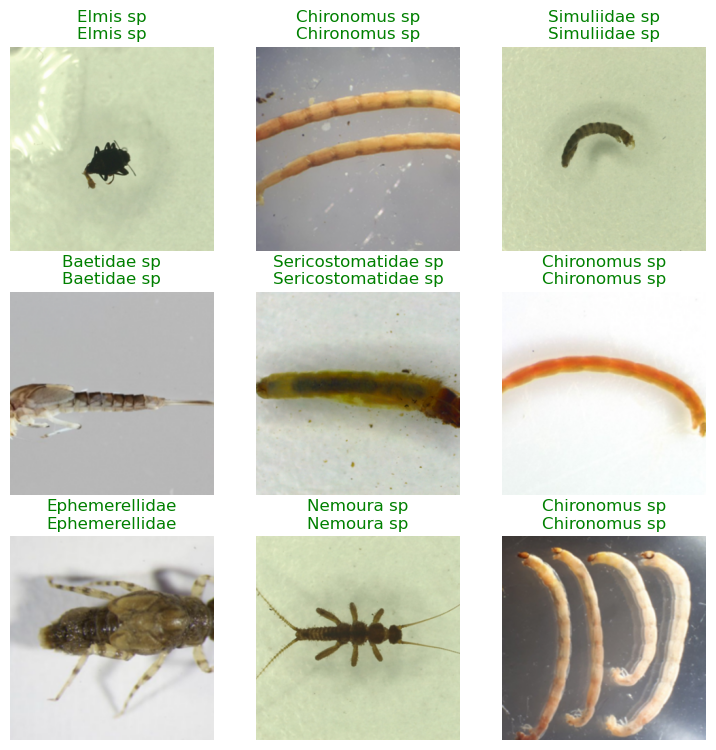

In [5]:
learn.show_results()

In [6]:
interpreter = ClassificationInterpretation.from_learner(learn)

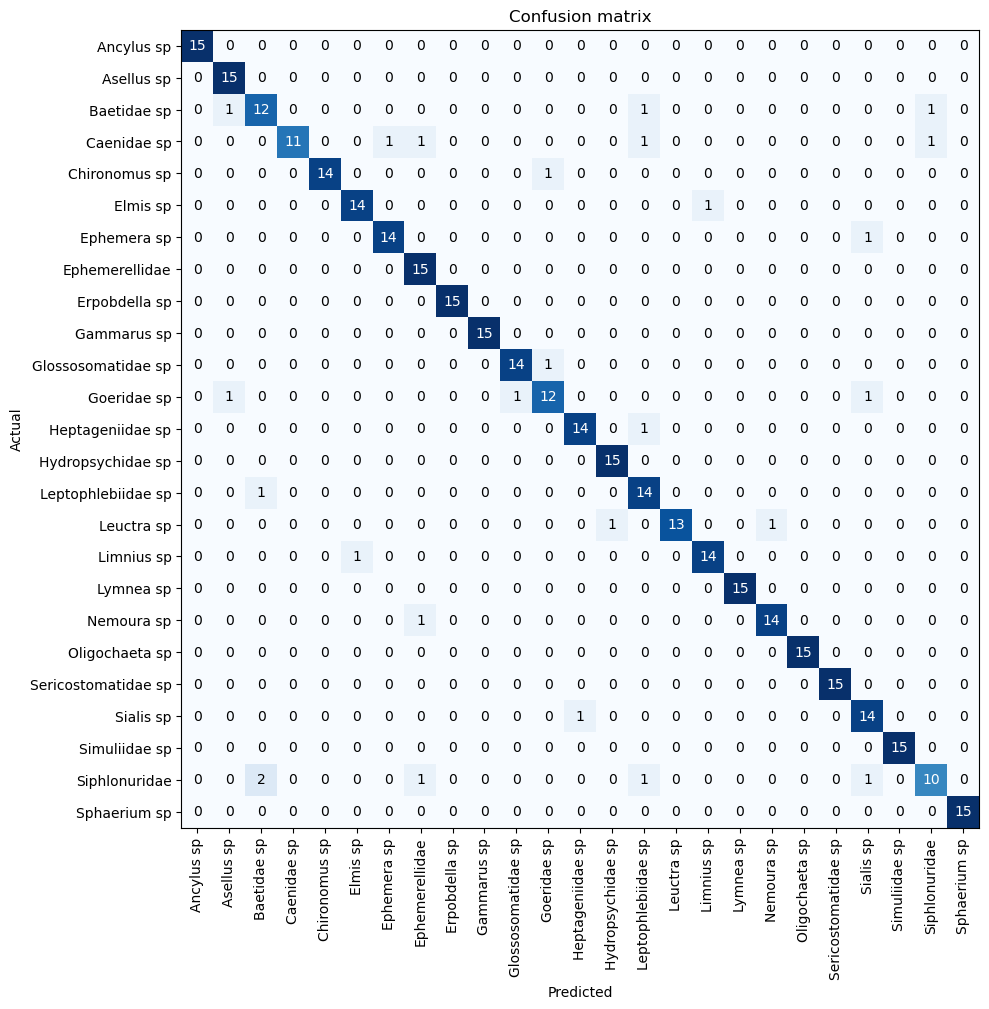

In [7]:
interpreter.plot_confusion_matrix(figsize=(10,10))

In [29]:
timm_model = timm.create_model(model_name, pretrained=True, num_classes = n_classes)
timm_model.default_cfg

{'url': 'https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'stem.0',
 'classifier': 'head.fc',
 'architecture': 'convnext_tiny'}

In [30]:
#timm_model.load_state_dict(learn.model.cpu().state_dict(), strict=False)

In [31]:
#Define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#Define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#Assemble the final model
final_model = nn.Sequential(normalization_layer, torch_model, softmax_layer)
final_model.eval()

Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
                (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Linear(in_features=96, out_features=384, bias=True)
                  (act): GELU(approximate=none)
                  (drop1): Dropout(p=0.0, inplace=False)
                  (fc2): Linear(in_features=384, out_features=96, bias=True)
                  (drop2): Dropout(p=0.0, inplac

In [32]:
#Generate model sample input
dummy_input = torch.randn(1, 3, img_size, img_size, requires_grad=True)

onnx_model_path = model_dir/f"{model_name}.onnx"

In [33]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#Model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    opset_version=12,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

In [34]:
#Test ONNX model and fastai predictions
image_sample = "image_preproc/valid/Nemoura sp/CPH-Nemoura sp.-2262.png"

In [35]:
spec, idx, probs = learn.predict(image_sample)
top5_probs, top5_idx = torch.topk(probs, 5)

In [36]:
#Nemoura sp. (90%)
#Heptageniidae sp. (4%)
#Leuctra sp. (1%)
#...

In [37]:
model = cv2.dnn.readNetFromONNX(f"models/{model_name}.onnx")

In [38]:
model_input = cv2.dnn.blobFromImage(
                image = cv2.imread(image_sample),
                scalefactor = 1/255,
                size = (img_size, img_size),
                swapRB=True,
                crop=True)


In [39]:
model.setInput(model_input)
output = model.forward().squeeze()

error: OpenCV(4.6.0) /io/opencv/modules/dnn/include/opencv2/dnn/shape_utils.hpp:170: error: (-215:Assertion failed) start <= (int)shape.size() && end <= (int)shape.size() && start <= end in function 'total'


In [40]:
output, probs.numpy()

NameError: name 'output' is not defined

In [ ]:
#update opencv
#install shap and load resnet for investigation
